In [1]:
import pandas as pd
from pandas_datareader import data as pdr

import numpy as np
from scipy.stats import norm
from scipy.interpolate import griddata
from scipy import optimize

import matplotlib.pyplot as plt
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import yfinance as yf
yf.pdr_override()

from datetime import date
from datetime import datetime

# Useful functions
def SaveFig(filename):
    plt.savefig(r'fig/'+filename)

def SaveData(df, filename):
    df.to_csv(r'data/'+filename+'.csv')

In [2]:
# Call Option Valuation Using Black-Scholes
def BS_VCall(S,mu,sigma,K,T):
    d1 = (np.log(S/K) + (mu + 1/2 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C  = S * norm.cdf(d1) - K * norm.cdf(d2) * np.exp(-1 * mu * T)
    return np.round(C,4)

def Implied_SD(S,mu,K,T,price):
    f = lambda sigma: BS_VCall(S, mu, sigma, K, T) - price
    return optimize.newton(f, 0.1) 

In [3]:
# Get Call Options Data
ticker = 'AAPL'

today = date.today()
dates = pd.date_range(today, periods=100).tolist()
for i,d in enumerate(dates):
    dates[i] = dates[i].strftime("%Y-%m-%d")

df = pd.DataFrame()
for i,T in enumerate(dates):
    try:
        calls = yf.Ticker(ticker).option_chain(T).calls
        calls['expiration'] = (datetime.strptime(T,"%Y-%m-%d").date() - today).days
        df = df.append(calls)
    except:
        pass

In [4]:
# Cleaning Data
df = df[df.impliedVolatility > 0.001]
df = df[df.impliedVolatility <= 1]
df = df[df.expiration > 0]
df = df.reset_index(drop=True)
df = df[['contractSymbol','strike','expiration','impliedVolatility','lastPrice']]

SaveData(df, ticker + ' call options')

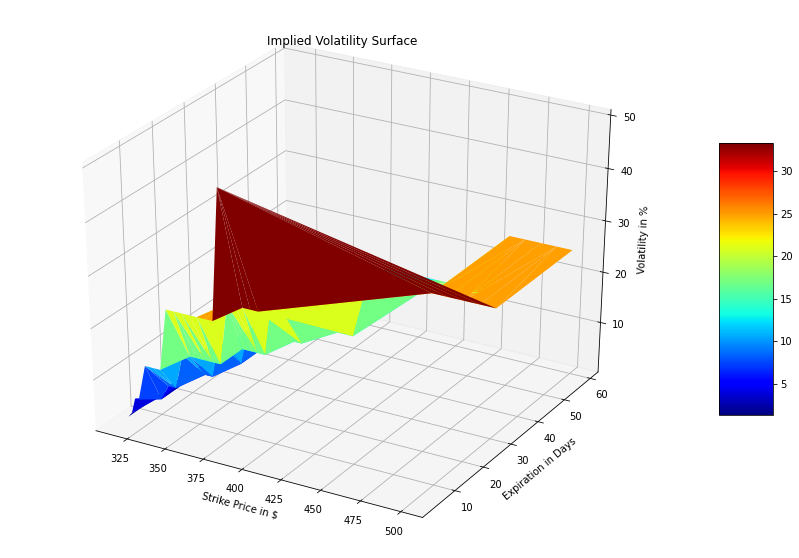

In [5]:
# Implied Volatility Surface Using Available Data
fig = plt.figure(figsize = (15, 10))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df['strike'], df['expiration'], round(df['impliedVolatility'],2) * 100, 
                     cmap=plt.cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Strike Price in $')
ax.set_ylabel('Expiration in Days')
ax.set_zlabel('Volatility in %')
ax.set_title('Implied Volatility Surface')
plt.show()

In [6]:
# Implied Volatility Surface Using BS Solving
S     = yf.download(ticker,period = "1d",progress=False)['Adj Close'][0]
r     = 0.0178

#df['sigma'] = 0.5
#for i in range(0,len(df['strike'])-1):
    #df['sigma'][i] = Implied_SD(S,r,df['strike'][i],df['expiration'][i],df['lastPrice'][i])

In [ ]:
BS_VCall(S,0.5,0.004,310.0,0.019)

In [16]:
df    = pd.read_csv(r'data/quotedata.dat', sep=',')
calls = df[['Expiration Date','Calls','Last Sale','Net','Bid','Ask','Vol','IV',
            'Delta','Gamma','Open Int','Strike']]
puts  = df[['Expiration Date','Puts','Last Sale.1','Net.1','Bid.1','Ask.1','Vol.1','IV.1',
            'Delta.1','Gamma.1','Open Int.1']]